# Problem Set 3

*21 November, 2021* 

## Preparing the environment

In [1]:
using Pkg
cd("/Users/xkong/Dropbox/Study/Grad@UChicago/2021Fall/Labor-Lamadon/psets/ps3")
Pkg.activate(".") # Create new environment in this folder

# Install dependencies
Pkg.add(["Distributions","StatsBase","DataFrames","DataFramesMeta","Chain","Plots","StatsPlots","Random","LinearAlgebra","ShiftedArrays","CategoricalArrays","NLsolve","StatFiles","GLM","FixedEffectModels"]);

# Instantiate the current folder
Pkg.instantiate() # Updates packages given .toml file

  Activating environment at `~/Dropbox/Study/Grad@UChicago/2021Fall/Labor-Lamadon/psets/ps3/Project.toml`
    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/Dropbox/Study/Grad@UChicago/2021Fall/Labor-Lamadon/psets/ps3/Project.toml`
  No Changes to `~/Dropbox/Study/Grad@UChicago/2021Fall/Labor-Lamadon/psets/ps3/Manifest.toml`


In [2]:
using Distributions,StatsBase,DataFrames,DataFramesMeta,Chain,Plots,StatsPlots,Random,LinearAlgebra,ShiftedArrays,CategoricalArrays,NLsolve,StatFiles,GLM,FixedEffectModels

global_seed = 12345
Random.seed!(global_seed);

## Simulate Data

Here, we define the parameter $\theta$ to be estimated.
- $p_k$: distribution for mixtures $k$
- $A$: matrix of means, row - t, column - k
- $S$: matrix of standard deviations, row - t, column - k

In [3]:
nt = 3  # number of periods
nk = 3  # number of types 

function generate_model(nt,nk)
  # model for Y1,Y2,Y3 | k 
  # pk = rand(Dirichlet(3,2),1)  # conjugate prior for Categorical or Multinomial distributions
  # A = reshape(2 .* (1 .+ rand(nt*nk)), (nt,nk))
  # S = reshape(0.1.*(1 .+ rand(nt*nk)), (nt,nk))
  pk = [0.5; 0.3; 0.2]
  A = [1.0 2.0 3.0; 1.25 2.25 3.25; 1.5 2.5 3.5]
  S = reshape(0.1.*(1 .+ rand(nt*nk)), (nt,nk))
  return (pk,A,S,nt,nk)
end

data_model = generate_model(nt,nk);

Then, we draw outcomes $Y_1,Y_2,Y_3$ given $A$ and $S$.

In [4]:
N = 10000

function simulate_data(data_model,N;sd_scale=1)
  
  Y1 = zeros(N,1) 
  Y2 = zeros(N,1) 
  Y3 = zeros(N,1) 
  K  = zeros(Int,N,1) 
    
  pk = data_model[1]
  A  = data_model[2]
  S  = data_model[3]
  nt = data_model[4]
  nk = data_model[5]
  
  # draw k and Y
  for n = 1:N
    k = sample(1:nk, Weights(pk[:]))  # draw type k
    K[n] = k
    # draw Y1, Y2, Y3 given k
    Y1[n] = A[1,k] .+ S[1,k] .* rand(Normal()) .* sd_scale
    Y2[n] = A[2,k] .+ S[2,k] .* rand(Normal()) .* sd_scale
    Y3[n] = A[3,k] .+ S[3,k] .* rand(Normal()) .* sd_scale
  end
  
  return DataFrame(k=K[:],y1=Y1[:],y2=Y2[:],y3=Y3[:])
end

simdata = simulate_data(data_model,N;sd_scale=1);

Plot the distributions of $Y$'s by time $t$ and type $k$.

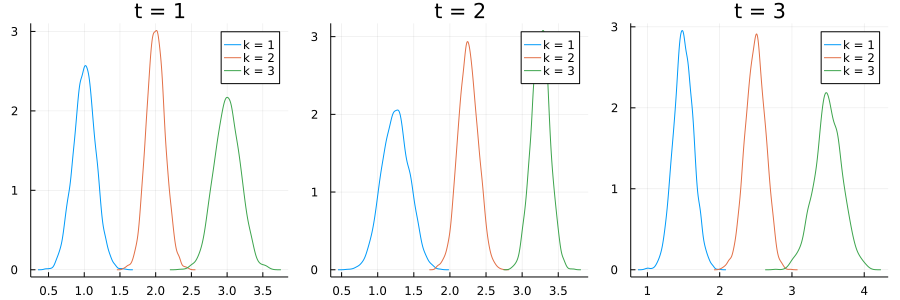

In [5]:
simdata1 = @subset(simdata, :k.==1)
simdata2 = @subset(simdata, :k.==2)
simdata3 = @subset(simdata, :k.==3)

p1 = density(simdata1.y1, title = "t = 1", label = "k = 1")
density!(simdata2.y1, label = "k = 2")
density!(simdata3.y1, label = "k = 3")

p2 = density(simdata1.y2, title = "t = 2", label = "k = 1")
density!(simdata2.y2, label = "k = 2")
density!(simdata3.y2, label = "k = 3")

p3 = density(simdata1.y3, title = "t = 3", label = "k = 1")
density!(simdata2.y3, label = "k = 2")
density!(simdata3.y3, label = "k = 3")

plot(p1,p2,p3, layout = (1,3), size=(900,300))

In [6]:
# log of normal pdf
function lognormpdf(Y, A, S) 
    return -0.5 .* ((Y.-A)./S).^2 .- 0.5 .* log(2*pi) .- log.(S)
end;

function logsumexp(v)
    vmax = maximum(v)
    return log(sum(exp.(v .- vmax))) + vmax
end;

## EM Estimation

We describe the EM procedures in detail. 

### Setup

Person $i$ has a latent type, denoted $\eta_i$. There are finite number of types $\eta_i = k \in \{1,...,K\}$. The probability of being type $k$ is $p_k$. 

For a person with type $k$, we observe an outcome vector $Y_i$, where Y_i is drawn from a normal distribution with mean $A_k$ and standard deviation $S_k$. 

We want to estimate $p_k$, $A_k$, and $S_k$ for all $k$. We adopt a two-step (nested optimization) approach where we update $p_k$ and $\{A_{k},S_{k}\}$ iteratively. 

The log-likelihood function is
$$ L(\theta) = \sum_{i=1}^N \log Pr(Y_{i} | \theta) $$
where $\theta$ is vector that contains $\{p_k,A_{k},S_{k}\}$.

Using the definition of conditional probability, we have
$$ Pr(Y_{i} | \theta) = \frac{Pr(Y_{i}, \eta_i | \theta)}{Pr(\eta_i | Y_{i}, \theta)}$$
We can replace the term in the likelihood function by the fraction above. In addition, using the law of total probability, we can write $L(\theta)$ as
\begin{align*}
L(\theta|\theta^{\tau}) &= \sum_{i=1}^N \sum_{k=1}^K Pr(\eta_i = k | Y_{i},\theta^\tau) \left( \log Pr(Y_{i}, \eta_i = k | \theta) - \log Pr(\eta_i=k | Y_{i}, \theta) \right) \\
&= \underbrace{\sum_{i=1}^N \sum_{k=1}^K Pr(\eta_i = k | Y_{i},\theta^\tau) \log Pr(Y_{i}, \eta_i = k | \theta)}_{Q(\theta|\theta^\tau)} \underbrace{- \sum_{i=1}^N \sum_{k=1}^K Pr(\eta_i = k | Y_{i},\theta^\tau) \log Pr(\eta_i=k | Y_{i}, \theta)}_{H(\theta|\theta^\tau)}
\end{align*}



### The E-Step

Guess $\theta^\tau = \{p_k^\tau,A_{k}^\tau,S_{k}^\tau\}$. $p_k^\tau$ is our prior, and we can compute the posterior for each $i$ using Bayes Law.
$$ q_i(k) \equiv Pr(\eta_i = k | Y_{i},\theta^\tau) = \frac{p_k^\tau Pr(Y_{i} | \eta_i = k,\theta^\tau)}{\sum_{k'=1}^K p_{k'}^\tau Pr(Y_{i} | \eta_i = k',\theta^\tau)} $$

### The M-Step

Given posterior $q_i(k)$, we can maximize $Q(\theta|\theta^\tau)$. We can solve for $\theta^{\tau+1}$ using the FOCs.

Since $\theta^{\tau+1}$ is chosen to maximize $Q(\theta|\theta^\tau)$, $Q(\theta|\theta^\tau)$ is always increasing. Moreover, $H(\theta^{\tau+1}|\theta^\tau) > H(\theta^{\tau}|\theta^\tau)$ because
\begin{align*}
    H(\theta^{\tau+1}|\theta^\tau) - H(\theta^{\tau}|\theta^\tau) = \sum_{i=1}^N \sum_{k=1}^K Pr(\eta_i = k | Y_{i},\theta^\tau) \log \frac{Pr(\eta_i=k | Y_{i}, \theta^{\tau})}{Pr(\eta_i=k | Y_{i}, \theta^{\tau+1})} \geq 0
\end{align*}
by non-negativity of the Kullback-Liebler divergence. Since both $Q$ and $H$ are increasing, likelihood $L(\theta|\theta^{\tau})$ is increasing, and we can iterate these two steps until convergence. The resulting $\theta^{\tau+1}$ is the ML estimator for true $\theta$.

### Applying EM

In the case described here, we can compute the posterior
$$ q_i(k) = \frac{p_k^\tau \prod_{t=1}^T \phi(Y_{it} | \eta_i = k,\theta^\tau)}{\sum_{k'=1}^K p_{k'}^\tau \prod_{t=1}^T \phi(Y_{it} | \eta_i = k',\theta^\tau)} $$

The $Q$ function takes an explicit form under normality.
\begin{align*}
Q(\theta|\theta^\tau) &= \sum_{i=1}^N \sum_{k=1}^K q_i(k) \left( \log p_k + \sum_{t=1}^T \log \phi(Y_{it}|\eta_i = k, \theta) \right) \\
&= \sum_{i=1}^N \sum_{k=1}^K q_i(k) \left( \log p_k + \sum_{t=1}^T \left( -\frac{1}{2}\log(2\pi) - \log S_{kt} - \frac{(Y_{it}-A_{kt})^2}{2S_{kt}^2} \right) \right) 
\end{align*}

The FOCs are given by
\begin{align*}
[A_{kt}]: & \sum_i q_i(k) \frac{Y_{it}-A_{kt}}{S_{kt}^2} = 0 \implies A_{kt}^{\tau+1} = \sum_i \frac{q_i(k)}{\sum_j q_j(k)} Y_{it} \\ 
[S_{kt}]: & \sum_i q_i(k) \left( -\frac{1}{S_{kt}} + \frac{(Y_{it}-A_{kt})^2}{S_{kt}^3} \right) = 0 \implies S_{kt}^{\tau+1} = \sqrt{\sum_i \frac{q_i(k)}{\sum_j q_j(k)} (Y_{it}-A_{kt}^{\tau+1})^2}
\end{align*}

Apply LLN to update $p_k^{\tau+1}$
$$ p_k^{\tau+1} = \frac{1}{N} \sum_i q_i(k) $$

The code below implements this procedure.

#### Question 1: Write a function that takes the data in, and estimates the parameters of the mixture model. To that end, you can use the supplied code if you want. You need to write a loop that alternates between the expectation and the maximization step. You need to then add a termination condition. You can for instance check that the likelihood changes by very little.

#### Question 2: Extend your EM function to include the computation of the Q and H functions at every step. Note that this function needs to take in both the previous and new parameters (or at least the last $\omega_{ik}$).

In [7]:
function E_step(data,pk,A,S,nt,nk,N)

    Y1 = data.y1;
    Y2 = data.y2;
    Y3 = data.y3;

    ω = zeros(N,nk) # posterior
    lpm = zeros(N,nk)
    lik = 0
    for n = 1:N
        lnorm1 = lognormpdf(Y1[n], A[1,:], S[1,:])
        lnorm2 = lognormpdf(Y2[n], A[2,:], S[2,:])
        lnorm3 = lognormpdf(Y3[n], A[3,:], S[3,:])
        lall = log.(pk) .+ lnorm1 .+ lnorm2 .+ lnorm3
        lpm[n,:] = lall
        lik = lik + logsumexp(lall)
        ω[n,:] = exp.(lall .- logsumexp(lall))
    end

    return (ω,lpm,lik)
end;

In [8]:
function M_step(data,ω,nt,nk,N)

    Y1 = data.y1;
    Y2 = data.y2;
    Y3 = data.y3;

    pk = sum(ω,dims=1)' ./ N
    A = zeros(nt,nk)
    S = zeros(nt,nk)

    for k = 1:nk
        weight = ω[:,k] ./ sum(ω[:,k])
        A[1,k] = sum(Y1, weights(weight))
        A[2,k] = sum(Y2, weights(weight))
        A[3,k] = sum(Y3, weights(weight))

        S[1,k] = sqrt(sum((Y1.-A[1,k]).^2, weights(weight)))
        S[2,k] = sqrt(sum((Y2.-A[2,k]).^2, weights(weight)))
        S[3,k] = sqrt(sum((Y3.-A[3,k]).^2, weights(weight)))
    end

    return (pk,A,S)
end;

In [9]:
function EM(data,pk0,A0,S0,nt,nk,N;tol=1e-10,max_iter=100,print_iter=1)
    # solve for stuff under initial guesses
    ω0,lpm0,lik0 = E_step(simdata,pk0,A0,S0,nt,nk,N)
    Q0 = sum(ω0 .* lpm0)
    H0 = - sum(ω0 .* log.(ω0))

    Qiter = zeros(0)
    Hiter = zeros(0)
    LIKiter = zeros(0) 

    for i = 1:max_iter
        pk,A,S = M_step(data,ω0,nt,nk,N)
        ω1,lpm1,lik1 = E_step(data,pk,A,S,nt,nk,N)
        
        # compute Q and H
        Q1 = sum(ω0 .* lpm1)
        H1 = - sum(ω0 .* log.(ω1))
        
        if print_iter==1
            println("Iteration $i: increases in Q, H, and likelihood are $(Q1-Q0), $(H1-H0), and $(lik1-lik0)")
        end

        diff = lik1 - lik0
        if diff < tol
            break
        else
            ω0 = ω1
            lpm0 = lpm1
            Q0 = sum(ω0 .* lpm0)
            H0 = - sum(ω0 .* log.(ω0))
            lik0 = lik1

            Qiter = append!(Qiter, Q0) 
            Hiter = append!(Hiter, H0)
            LIKiter = append!(LIKiter, lik0)
        end 
    end
    
    pk_sol,A_sol,S_sol = M_step(data,ω0,nt,nk,N);
    ω_sol,lpm_sol,lik_sol = E_step(data,pk_sol,A_sol,S_sol,nt,nk,N);

    Qiter = append!(Qiter, sum(ω_sol .* lpm_sol))
    Hiter = append!(Hiter, - sum(ω_sol .* log.(ω_sol)))
    LIKiter = append!(LIKiter, lik_sol)

    return (pk_sol,A_sol,S_sol,ω_sol,lpm_sol,lik_sol,Qiter,Hiter,LIKiter)
end;

#### Question 3: Simulate from this model, use your function to estimate the parameters from the data. Show that you do recover all the parameters (plot estimated values versus true values). Finally, also report the sequence of values of the likelihood, the H function and the Q function. When you update your estimator, make sure your function returns a list structure similar to the one presented right here. This way you can use the simulation code right away.

In [10]:
# initial guesses
Random.seed!(global_seed)
pk0 = rand(Dirichlet(nk,2),1)
A0 = reshape(1 .+ rand(nt*nk), (nt,nk))
S0 = reshape(1 .+ rand(nt*nk), (nt,nk))

pk_test,A_test,S_test,ω_test,lpm_test,lik_test,Qiter,Hiter,LIKiter = EM(simdata,pk0,A0,S0,nt,nk,N;tol=1e-10,max_iter=100,print_iter=1);

Iteration 1: increases in Q, H, and likelihood are 10942.74411265819, 1305.4192389927466, and 12248.163351650786
Iteration 2: increases in Q, H, and likelihood are 3602.7855962211324, 3969.8539232928215, and 7572.639519514047
Iteration 3: increases in Q, H, and likelihood are 7117.048041217524, 5302.760236461476, and 12419.80827767894
Iteration 4: increases in Q, H, and likelihood are 10427.299885439777, 3354.798114309503, and 13782.097999749281
Iteration 5: increases in Q, H, and likelihood are 3502.6778295064496, 29.121883628190474, and 3531.7997131346488
Iteration 6: increases in Q, H, and likelihood are 0.2744151899910321, 5.539425734728172e-13, and 0.27441518997511594
Iteration 7: increases in Q, H, and likelihood are 4.547473508864641e-13, 4.963083675318166e-24, and -2.2737367544323206e-12


In [11]:
println("============================================================")
println("Estimated pk: $(round.(pk_test, digits = 3))")
println("Actual pk: $(data_model[1])")
println("============================================================")
println("Estimated A: $(round.(A_test, digits = 3))")
println("Actual A: $(data_model[2])")
println("============================================================")
println("Estimated S: $(round.(S_test, digits = 3))")
println("Actual S: $(round.(data_model[3], digits = 3))")

Estimated pk: [0.503; 0.299; 0.198]
Actual pk: [0.5, 0.3, 0.2]
Estimated A: [1.001 2.0 3.001; 1.248 2.251 3.255; 1.499 2.493 3.499]
Actual A: [1.0 2.0 3.0; 1.25 2.25 3.25; 1.5 2.5 3.5]
Estimated S: [0.155 0.13 0.182; 0.189 0.137 0.126; 0.138 0.138 0.193]
Actual S: [0.156 0.128 0.184; 0.185 0.138 0.126; 0.137 0.137 0.192]


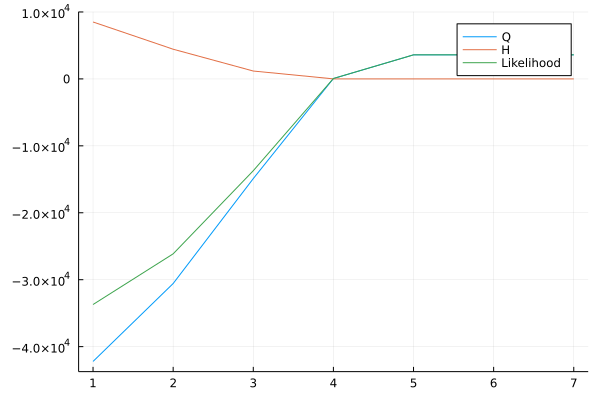

In [12]:
iter = length(Qiter)
plot(1:iter, Qiter, label = "Q")
plot!(1:iter, Hiter, label = "H")
plot!(1:iter, LIKiter, label = "Likelihood")

#### Question 4: Use your function to estimate the mixture model on this data. Try to estimate for different number of mixture component (3,4,5). For each set of parameters, report how much of the cross-sectional dispersion in wages can be attributed to permanent heterogeneity ηi and how much to the rest. Finally, we want to assess the fit of the model, to do that, simulate from your estimated model, then plot the quantiles from your simulated data in the cross-section versus the one in the data.

In [13]:
PSID = DataFrame(load("AER_2012_1549_data/output/data4estimation.dta"));
PSID[!,[:person,:year,:marit]] = convert.(Int,PSID[:,[:person,:year,:marit]])
PSID[!,[:state_st]] = convert.(String,PSID[:,[:state_st]])
sort!(PSID, [:person,:year]);
# PSID[:,[:person,:year,:log_y,:marit,:state_st]]

In [14]:
PSID[:,:log_yr] = reg(PSID, @formula(log_y ~ fe(year) + fe(state_st)), save = true).residuals;

PSID_df = @chain PSID begin
    groupby(:person)
    transform(:log_yr => (x -> lag(x,2)) => :y1)
    groupby(:person)
    transform(:log_yr => (x -> lag(x,1)) => :y2)
    @transform(:y3 = :log_yr)
    @transform(:miss = :y1 + :y2 + :y3)
    @subset(ismissing.(:miss).!=1)
    select([:person,:y1,:y2,:y3])
end;

In [15]:
function EM_alter_mixtures(data,K;print_iter=1)
    T = 3
    Nobs = size(data)[1]

    Random.seed!(global_seed)
    pk0 = rand(Dirichlet(K,2),1)
    A0 = reshape(1 .+ rand(T*K), (T,K))
    S0 = reshape(1 .+ rand(T*K), (T,K))

    pk_sol,A_sol,S_sol,ω_sol,lpm_sol,lik_sol,Qiter,Hiter,LIKiter = EM(data,pk0,A0,S0,T,K,Nobs;tol=1e-10,max_iter=1000,print_iter=print_iter);

    ## How to decompose variation in wages into a permanent component and other components?
    # reg log wage on k fixed effects
    data[:,:k] = getindex.(argmax(ω_sol,dims=2),2)[:]
    data[:,:y1_perm] = reg(data, @formula(y1 ~ fe(k)), save = true).fe.fe_k
    data[:,:y2_perm] = reg(data, @formula(y2 ~ fe(k)), save = true).fe.fe_k
    data[:,:y3_perm] = reg(data, @formula(y3 ~ fe(k)), save = true).fe.fe_k
    var_decon = DataFrame(t=1:T, var_y=[var(data.y1);var(data.y2);var(data.y3)], var_perm=[var(data.y1_perm);var(data.y2_perm);var(data.y3_perm)])
    var_decon[:,:var_perm_share] = var_decon[:,:var_perm] ./ var_decon[:,:var_y]

    # re-simulate the model and assess model fit
    estimated_model = (pk_sol,A_sol,S_sol,T,K)
    Nsim = 10000
    simdata_fit = simulate_data(estimated_model,Nsim;sd_scale=1)

    p1 = density(simdata_fit.y1, title = "t = 1", label = "Simulated")
    density!(data.y1, label = "Data")
    p2 = density(simdata_fit.y2, title = "t = 2", label = "Simulated")
    density!(data.y2, label = "Data")
    p3 = density(simdata_fit.y3, title = "t = 3", label = "Simulated")
    density!(data.y3, label = "Data")
    pp = plot(p1,p2,p3, layout = (1,3), size=(900,300))

    return (pk_sol,A_sol,S_sol,ω_sol,lpm_sol,lik_sol,Qiter,Hiter,LIKiter,T,K,var_decon,simdata_fit,pp)
end;

In [16]:
output = []
for K in [3,4,5]
    output = append!(output, EM_alter_mixtures(PSID_df,K;print_iter=0))
end

In [17]:
var_decon_3mix = output[12]
var_decon_4mix = output[26]
var_decon_5mix = output[40]

println("============================================================")
println("Using 3 mixtures:")
println(var_decon_3mix)
println("============================================================")
println("Using 4 mixtures:")
println(var_decon_4mix)
println("============================================================")
println("Using 5 mixtures:")
println(var_decon_5mix)

Using 3 mixtures:
3×4 DataFrame
 Row │ t      var_y     var_perm  var_perm_share 
     │ Int64  Float64   Float64   Float64        
─────┼───────────────────────────────────────────
   1 │     1  0.47977   0.278091        0.579635
   2 │     2  0.490637  0.313605        0.639181
   3 │     3  0.552822  0.318582        0.576283
Using 4 mixtures:
3×4 DataFrame
 Row │ t      var_y     var_perm  var_perm_share 
     │ Int64  Float64   Float64   Float64        
─────┼───────────────────────────────────────────
   1 │     1  0.47977   0.157465        0.328209
   2 │     2  0.490637  0.176089        0.358899
   3 │     3  0.552822  0.174           0.314749
Using 5 mixtures:
3×4 DataFrame
 Row │ t      var_y     var_perm  var_perm_share 
     │ Int64  Float64   Float64   Float64        
─────┼───────────────────────────────────────────
   1 │     1  0.47977   0.298228        0.621607
   2 │     2  0.490637  0.34022         0.693425
   3 │     3  0.552822  0.344432        0.623043


Simulated vs actual data, 3 mixtures:


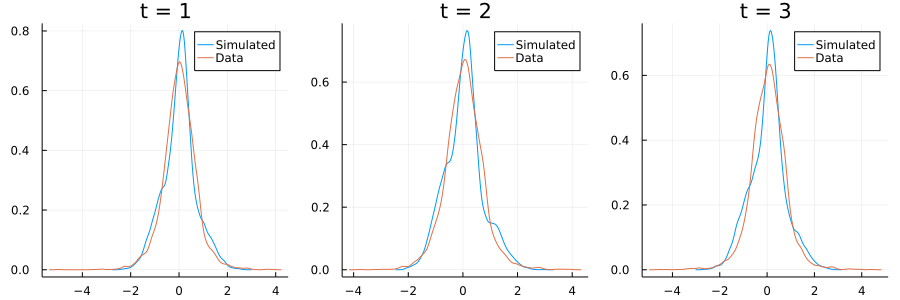

In [18]:
fit_3mix = output[14]
fit_4mix = output[28]
fit_5mix = output[42]

println("============================================================")
println("Simulated vs actual data, 3 mixtures:")
fit_3mix

Simulated vs actual data, 4 mixtures:


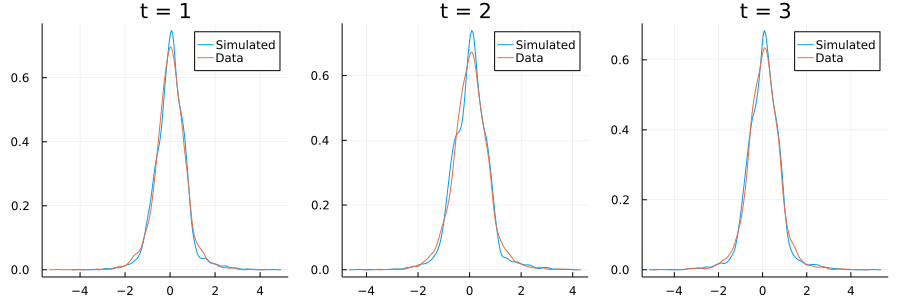

In [19]:
println("============================================================")
println("Simulated vs actual data, 4 mixtures:")
fit_4mix

Simulated vs actual data, 5 mixtures:


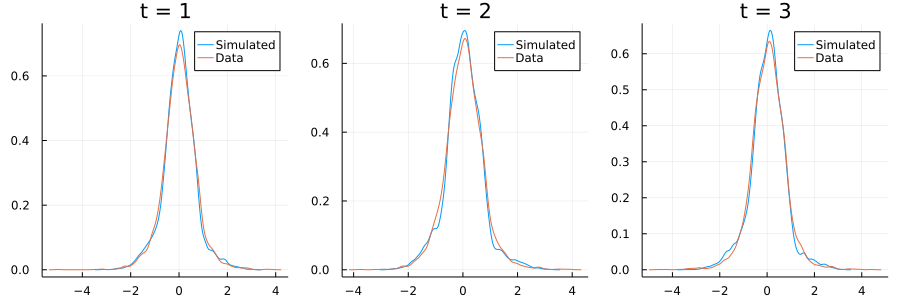

In [20]:
println("============================================================")
println("Simulated vs actual data, 5 mixtures:")
fit_5mix

#### Question 5: Use your function estimate the mixture model in differences using ρ=0.6. Next run your code on a grid for ρ between 0 and 1. Report the likelihood plot over the values of ρ and report the maximum likelihood estimator of ρ.

In [21]:
function EM_alter_ρ(data,ρ;print_iter=1)

    data_ρ = @chain data begin
        groupby(:person)
        transform(:log_yr => (x -> lag(x,3)) => :l3y)
        groupby(:person)
        transform(:log_yr => (x -> lag(x,2)) => :l2y)
        groupby(:person)
        transform(:log_yr => (x -> lag(x,1)) => :l1y)
        @transform(:y3 = :log_yr .- ρ .* :l1y)
        @transform(:y2 = :l1y .- ρ .* :l2y)
        @transform(:y1 = :l2y .- ρ .* :l3y)
        @transform(:miss = :y1 + :y2 + :y3)
        @subset(ismissing.(:miss).!=1)
        select([:person,:y1,:y2,:y3])
    end

    T = 3
    K = 3
    Nobs = size(data_ρ)[1]

    Random.seed!(global_seed)
    pk0 = rand(Dirichlet(K,2),1)
    A0 = reshape(1 .+ rand(T*K), (T,K))
    S0 = reshape(1 .+ rand(T*K), (T,K))

    pk_sol,A_sol,S_sol,ω_sol,lpm_sol,lik_sol,Qiter,Hiter,LIKiter = EM(data_ρ,pk0,A0,S0,T,K,Nobs;tol=1e-10,max_iter=1000,print_iter=print_iter);

    return (pk_sol,A_sol,S_sol,ω_sol,lpm_sol,lik_sol,Qiter,Hiter,LIKiter,T,K,data_ρ)
end;

In [22]:
pk_sol,A_sol,S_sol,ω_sol,lpm_sol,lik_sol,Qiter,Hiter,LIKiter,T,K,data_ρ = EM_alter_ρ(PSID,0.6;print_iter=0)

println("When ρ = 0.6")
println("Estimated pk:", round.(pk_sol,digits=3))
println("Estimated A:", round.(A_sol,digits=3))
println("Estimated S:", round.(S_sol,digits=3))


When ρ = 0.6
Estimated pk:[0.35; 0.305; 0.345]
Estimated A:[0.004 -0.11 0.19; 0.022 -0.117 0.187; 0.013 -0.136 0.191]
Estimated S:[0.718 0.188 0.173; 0.724 0.191 0.178; 0.784 0.193 0.175]


In [23]:
ρ_grid = 0.0:0.02:1
lik_grid = zeros(length(ρ_grid),1)

for i in 1:length(ρ_grid)
    ρ = ρ_grid[i]
    println("Running ρ = $ρ ...")

    pk_sol,A_sol,S_sol,ω_sol,lpm_sol,lik_sol,Qiter,Hiter,LIKiter,T,K,data_ρ = EM_alter_ρ(PSID,ρ;print_iter=0)
    lik_grid[i] = lik_sol
end

Running ρ = 0.0 ...
Running ρ = 0.02 ...
Running ρ = 0.04 ...
Running ρ = 0.06 ...
Running ρ = 0.08 ...
Running ρ = 0.1 ...
Running ρ = 0.12 ...
Running ρ = 0.14 ...
Running ρ = 0.16 ...
Running ρ = 0.18 ...
Running ρ = 0.2 ...
Running ρ = 0.22 ...
Running ρ = 0.24 ...
Running ρ = 0.26 ...
Running ρ = 0.28 ...
Running ρ = 0.3 ...
Running ρ = 0.32 ...
Running ρ = 0.34 ...
Running ρ = 0.36 ...
Running ρ = 0.38 ...
Running ρ = 0.4 ...
Running ρ = 0.42 ...
Running ρ = 0.44 ...
Running ρ = 0.46 ...
Running ρ = 0.48 ...
Running ρ = 0.5 ...
Running ρ = 0.52 ...
Running ρ = 0.54 ...
Running ρ = 0.56 ...
Running ρ = 0.58 ...
Running ρ = 0.6 ...
Running ρ = 0.62 ...
Running ρ = 0.64 ...
Running ρ = 0.66 ...
Running ρ = 0.68 ...
Running ρ = 0.7 ...
Running ρ = 0.72 ...
Running ρ = 0.74 ...
Running ρ = 0.76 ...
Running ρ = 0.78 ...
Running ρ = 0.8 ...
Running ρ = 0.82 ...
Running ρ = 0.84 ...
Running ρ = 0.86 ...
Running ρ = 0.88 ...
Running ρ = 0.9 ...
Running ρ = 0.92 ...
Running ρ = 0.94 ...
Ru

ML estimator for ρ is 0.94


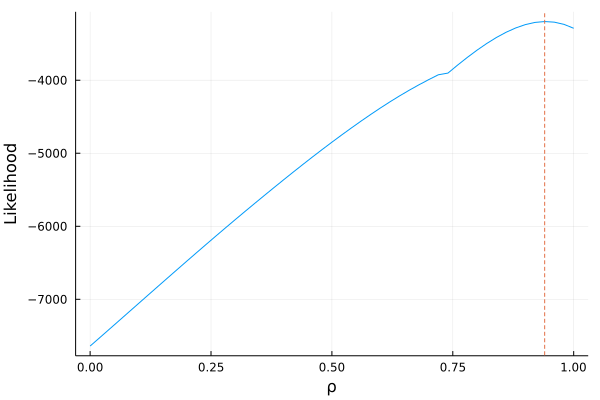

In [24]:
ρ_sol = ρ_grid[getindex(argmax(lik_grid),1)]
println("ML estimator for ρ is $ρ_sol")
plot(ρ_grid,lik_grid,legend=false,xlabel="ρ",ylabel="Likelihood")
plot!([ρ_sol], seriestype = :vline, linestyle = :dash)

#### Bonus questions, NP estimation using joint diagonalization